# LightGBM

In [4]:
import pandas as pd
import numpy as np
import os
import random
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import KFold
import pickle
from datetime import datetime
from tqdm.notebook import tqdm
import time
from IPython.display import Audio

## 1. Data Load

In [15]:
# Load Train Data
data_dir = '../input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
train_df = pd.read_csv(csv_file_path)

# Load Test Data
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)


## 2. Feature Engineering 함수

### elapsed_time & lag_time

In [17]:
# make elapsed_time & lag_time
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

def create_elapsed_time(df):
    prev_timestamp = df.groupby(['userID', 'testId'])[['time_stamp']].shift()
    df['elapsed_time'] = df['time_stamp'] - prev_timestamp['time_stamp']
    df['elapsed_time'] = df['elapsed_time'].fillna(0)
    return df

def create_lag_time(df):
    start_end_id_by_user_test = df.groupby(['userID','testId', 'day']).apply(lambda x: (x.index.values[0], x.index.values[-1])).reset_index()
    start_end_id_by_user_test = start_end_id_by_user_test.sort_values(by=[0]).reset_index(drop=True)
    start_row_id_by_user = start_end_id_by_user_test.groupby('userID').apply(lambda x: x.index.values[0])
    
    lag_time_list = [0]*len(df)
    for start_row, end_row in tqdm(start_end_id_by_user_test [0][1:]):
        start_time = df.time_stamp[start_row]
        prev_time = df.time_stamp[start_row-1]
        lag_time = start_time - prev_time
        lag_time_list[start_row:end_row+1] = [lag_time]*(end_row-start_row+1)
    
    # 사용자가 바뀌는 부분 첫 시험지 lag_time은 0으로 변경
    for user_start_idx in tqdm(start_row_id_by_user):
        start, end = start_end_id_by_user_test .loc[user_start_idx][0]
        lag_time_list[start:end+1] = [0]*(end-start+1)
    
    df['lag_time'] = lag_time_list
    
    return df

### user_recent_acc

In [18]:
# make user_recent_acc
def create_recent_acc(df, n=5):
    def custom(pr, cnt, n):
        if cnt < n:
            return 0
        else:
            return pr
    tmp_df = df.copy()
    user_start_idx = df['userID'].diff() > 0
    tmp_df['prior_ans_cnt']  = tmp_df.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    tmp_df['shift_prior_ans_cnt'] = tmp_df.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    tmp_df.loc[user_start_idx, ['prior_ans_cnt','shift_prior_ans_cnt']] = 0
    tmp_df['shift_prior_ans_cnt'] = tmp_df['shift_prior_ans_cnt'].shift(n)
    tmp_df['content'] = [1]*len(tmp_df)
    tmp_df['prior_quest_cnt'] = tmp_df.groupby('userID')['content'].cumsum().shift(fill_value=0)
    tmp_df['prior_quest_cnt'] = tmp_df['prior_quest_cnt'].apply(lambda x: n if x>n else x)
    tmp_df.loc[user_start_idx, ['prior_quest_cnt']] = 0
    tmp_df['shift_prior_ans_cnt'] = tmp_df.apply(lambda x: custom(x['shift_prior_ans_cnt'], x['prior_quest_cnt'], n), axis=1)
    tmp_df['cnt'] = tmp_df['prior_ans_cnt'] - tmp_df['shift_prior_ans_cnt'] 
    df[f'user_recent_acc_{n}'] = (tmp_df['cnt'] / tmp_df['prior_quest_cnt']).fillna(0)
    return df

### sum_rel_point

In [19]:
# make sum_rel_point, 'item_ans_rate' feature 사용
def fill_rel_point(df):
    arr = np.zeros(len(df))
    start_idx = 0

    for i in tqdm(range(len(df))):
        row = df.iloc[i, :].copy()
        answer = row['answerCode']
        item_ans_rate = row['item_ans_rate']

        if answer == 1:
            arr[i] = 1 - item_ans_rate
        elif answer == 0:
            arr[i] = - item_ans_rate
        elif answer == -1:
            
            avg_rel_point = np.mean(arr[start_idx : i])
            start_idx = i + 1 
            arr[i] = avg_rel_point

    df['rel_point'] = pd.Series(arr)
    return df

def sum_point(df):
    grouped = df.groupby('userID')['rel_point']
    arr = np.zeros(len(df))
    start_idx = 0
    cnt = 0
    for _, group in tqdm(grouped):
        cnt += 1
        point_sum = group.iloc[:len(group)-1].sum()
        arr[start_idx:start_idx+len(group)] = point_sum
        start_idx = start_idx + len(group)

    df['sum_rel_point'] = pd.Series(arr)
    return df

### knowledgetag_stroke

In [20]:
# tag 연속으로 나온 횟수
def knowledgetag_storke_feat_eng(df):
    knowledgetags = df.KnowledgeTag
    knowledgetag_stroke = np.zeros(knowledgetags.shape)
    
    for i, k in enumerate(knowledgetags):
        if i == 0:
            continue
    
        if k == knowledgetags[i-1]:
            knowledgetag_stroke[i] = knowledgetag_stroke[i-1] + 1
            
    df['knowledgetag_stroke'] = knowledgetag_stroke
    return df

### testPre & testPost

In [21]:
def testId_feat_eng(df):

    df['testPre'] = df.testId.map(lambda x: x[1:4])
    df['testPost'] = df.testId.map(lambda x: x[-3:])
    
    
    feat_test_preId = df.groupby('testPre')['answerCode'].agg(['mean', 'sum'])
    feat_test_preId.columns = ["test_preId_mean", 'test_preId_sum']
    feat_test_postId = df.groupby('testPost')['answerCode'].agg(['mean', 'sum'])
    feat_test_postId.columns = ["test_postId_mean", 'test_postId_sum']
    
    df = pd.merge(df, feat_test_preId, on=['testPre'], how="left")
    df = pd.merge(df, feat_test_postId, on=['testPost'], how="left")
    
    df['testPre'] = df.testPre.map(int)
    df['testPost'] = df.testPost.map(int)
    
    return df

### ktag_acc

In [22]:
# 매우 overfitting, 일단 폐기
# # 유저별 ktag별 정답률
# def user_ktag_acc(df):
#     def rate(values):
#         return sum(values) / len(values)
#     df['user_ktag_acc'] = df.groupby(['userID', 'KnowledgeTag']).answerCode.transform(rate)
#     return df

# def user_ktag_mean(df):
# # 유저별 ktag별 정답률과 ktag 전체 정답률(tag_mean) 평균
#     df['user_ktag_mean'] = (df['tag_mean'] + df['user_ktag_acc']) / 2
#     return df

### tag9_ans_rate

In [23]:
# 유저별 대분류 정답률
def tag9_ans_rate(df):
    df['tag9'] = df['testId'].apply(lambda x : x[2])
    def rate(values):
        return sum(values) / len(values)
    df['tag9_ans_rate'] = df.groupby(['userID', 'tag9']).answerCode.transform(rate)
    return df

### user_test_time_acc

In [24]:
def seperate_time(t):
    if t.hour < 6:
        # 새벽
        return 0
    elif t.hour < 12:
        # 오전
        return 1
    elif t.hour < 18:
        # 오후
        return 2
    else:
        # 밤
        return 3

def u_test_time_acc(df):
    timestamps = pd.to_datetime(df.Timestamp)
    timestamps = timestamps.map(seperate_time)
    df['test_time'] = timestamps
    def rate(values):
        return sum(values) / len(values)
    df['u_test_time_acc'] = df.groupby(['userID', 'test_time']).answerCode.transform(rate)
    return df

### feature_engineering 함수

In [25]:
def feature_engineering(df):
    assessmentItemID_mean_dict = df.groupby('assessmentItemID').mean().to_dict()
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    df['day'] = df.Timestamp.apply(lambda x:x.split()[0])
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'] = df['user_correct_answer'].fillna(0)
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['user_acc'] = df['user_acc'].fillna(0)

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    
    # custom features
    
    
    # item_ans_rate: 문항별 정답률
    df['item_ans_rate'] = df.assessmentItemID.map(assessmentItemID_mean_dict['answerCode'])
    
    # elapsed time & lag_time
    df['time_stamp'] = df['Timestamp'].apply(convert_time)
    df = create_elapsed_time(df)
    df = create_lag_time(df)
    
    # user_recent_acc
    for i in tqdm([5, 10, 30, 50, 100]):
        df = create_recent_acc(df, n=i)
    
    # sum_rel_point
    df = fill_rel_point(df)
    df = sum_point(df)
    # normalize sum_rel_point
    max_, min_ = max(df['sum_rel_point']), min(df['sum_rel_point'])
    df['sum_rel_point'] = (df['sum_rel_point'] - min_) / (max_ - min_)
    
    # user_ktag_acc 말도 안되게 overfitting됨.
#     df = user_ktag_acc(df)
    
    # tag9_ans_rate
    df = tag9_ans_rate(df)
    
    # knowledgetag_stroke
    df = knowledgetag_storke_feat_eng(df)
    
    # testPre & testPost
    df = testId_feat_eng(df)
    
    # u_test_time_acc(df) 유저별 시간대(test_time) 정답률
    df = u_test_time_acc(df)
    
    return df

## 3. Make Train/Valid Dataset

### Data split / FE

In [26]:
# make total_train dataset
total_train = pd.concat([train_df, test_df[test_df.answerCode!=-1]], ignore_index=True)

In [27]:
%%time
# FE total_train
total_train = feature_engineering(total_train)

  0%|          | 0/417882 [00:00<?, ?it/s]

  0%|          | 0/7442 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2525956 [00:00<?, ?it/s]

  0%|          | 0/7442 [00:00<?, ?it/s]

CPU times: user 18min 58s, sys: 21.7 s, total: 19min 20s
Wall time: 19min 15s


In [159]:
# total_train.to_csv("df/df.csv", index=False) # df -> csv

In [69]:
%%time
# VALID set: LEAVE LAST SECOND INTERACTION (users in test_data.csv)
test_tmp = test_df[test_df['answerCode'].isin([0, 1])]
valid = test_tmp[test_tmp['userID'] != test_tmp['userID'].shift(-1)]
y_valid = valid['answerCode']

CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 47.2 ms


In [37]:
# make train dataset
test_tr = test_tr.drop(valid.index)
train = pd.concat([train_df, test_tr], ignore_index=True)

# FE train / valid dataset
train = feature_engineering(train)
valid = feature_engineering(valid)

  0%|          | 0/417879 [00:00<?, ?it/s]

  0%|          | 0/7442 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2525212 [00:00<?, ?it/s]

  0%|          | 0/7442 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

## 4. 훈련 및 검증

### 평가지표 출력 함수 정의

In [42]:
def print_score(label, pred, prob_thres=0.5):
    print('PRINT VALIDATION SCORE')
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

### LightGBM cross validation out of fold train/predict 함수 정의

In [83]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score

In [84]:
FOLD = 10
def make_lgb_oof_pred(train, test, features, model_params=None):
    # train data의 answercode
    y = train['answerCode']
    
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score_auc = 0
    score_acc = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified Shuffle & Split
    
    ss = StratifiedShuffleSplit(n_splits=FOLD, test_size=0.5, random_state=0)
    
    for fold, (tr_idx, val_idx) in enumerate(ss.split(train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = train.loc[tr_idx, features], train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold}, x_train.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, y_tr)
        dvalid = lgb.Dataset(x_val,y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=100
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score_auc += roc_auc_score(y_val, val_preds) / FOLD
        score_acc += accuracy_score(y_val, np.where(val_preds >= 0.5, 1, 0)) / FOLD
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / FOLD
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score_auc}") # 폴드별 평균 Validation 스코어 출력
    print(f"Mean ACC = {score_acc}")
    print(f"\nOOF ACC = {accuracy_score(y, np.where(y_oof >= 0.5, 1, 0))}")
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

### 피처 중요도 플롯 함수 정의

In [85]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

In [86]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'day', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
       'item_ans_rate', 'time_stamp', 'elapsed_time', 'lag_time',
       'user_recent_acc_5', 'user_recent_acc_10', 'user_recent_acc_30',
       'user_recent_acc_50', 'user_recent_acc_100', 'rel_point',
       'sum_rel_point', 'tag9', 'tag9_ans_rate', 'knowledgetag_stroke',
       'testPre', 'testPost', 'test_preId_mean', 'test_preId_sum',
       'test_postId_mean', 'test_postId_sum', 'test_time', 'u_test_time_acc'],
      dtype='object')

### 사용할 feature 설정

In [87]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'tag_sum', 'test_sum', 'testPost', 'test_postId_mean', 'test_preId_mean',
         'user_acc', 'test_mean', 'tag_mean',
         'elapsed_time', 'lag_time', 'item_ans_rate', #'u_test_time_acc',
         'user_recent_acc_5', 'user_recent_acc_10', 'user_recent_acc_30', 'user_recent_acc_50', 'user_recent_acc_100',
        'sum_rel_point', 'knowledgetag_stroke', 'testPre', 'test_time']#, 'tag9_ans_rate']

### Hyperparameter 선언

In [88]:
SEED = 42
params = {'objective': 'binary',
          'metric': 'auc',
          'boosting_type': 'gbdt',
          'seed': 42,
          'num_leaves': 45,
          'learning_rate': 0.1
         }

### Train validation 성능 측정

In [89]:
%%time
y_oof, val_preds, fi_val = make_lgb_oof_pred(train, valid, FEATS, params)
print_score(y_valid, val_preds)
Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg", autoplay=True)

fold: 0, x_train.shape: (1262606, 21), x_val.shape: (1262606, 21)
[LightGBM] [Info] Number of positive: 826599, number of negative: 436007
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3715
[LightGBM] [Info] Number of data points in the train set: 1262606, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654677 -> initscore=0.639661
[LightGBM] [Info] Start training from score 0.639661
[100]	training's auc: 0.846497	valid_1's auc: 0.844763
Fold 0 | AUC: 0.8447629135519394
--------------------------------------------------------------------------------
fold: 1, x_train.shape: (1262606, 21), x_val.shape: (1262606, 21)
[LightGBM] [Info] Number of positive: 826591, number of negative: 436015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

### Feature importance plot

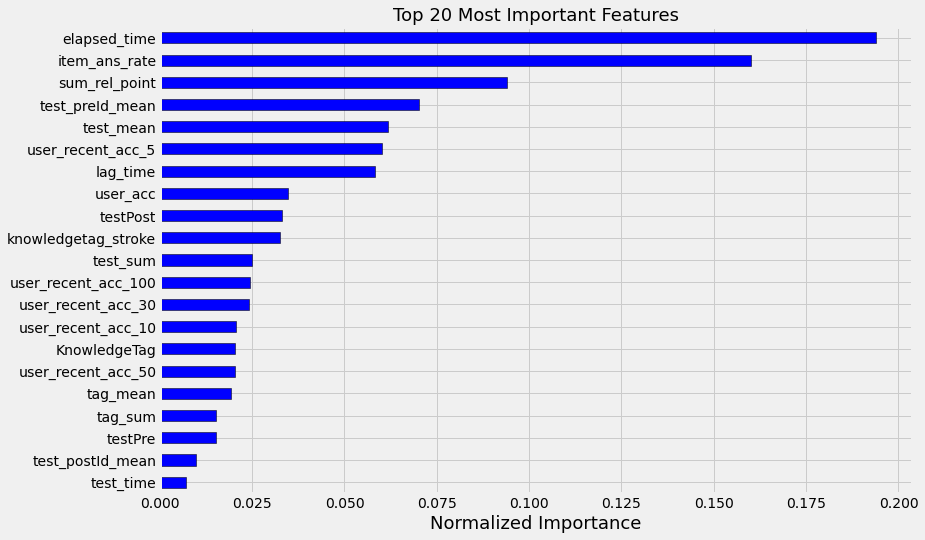

In [90]:
fi_lgb = plot_feature_importances(fi_val)

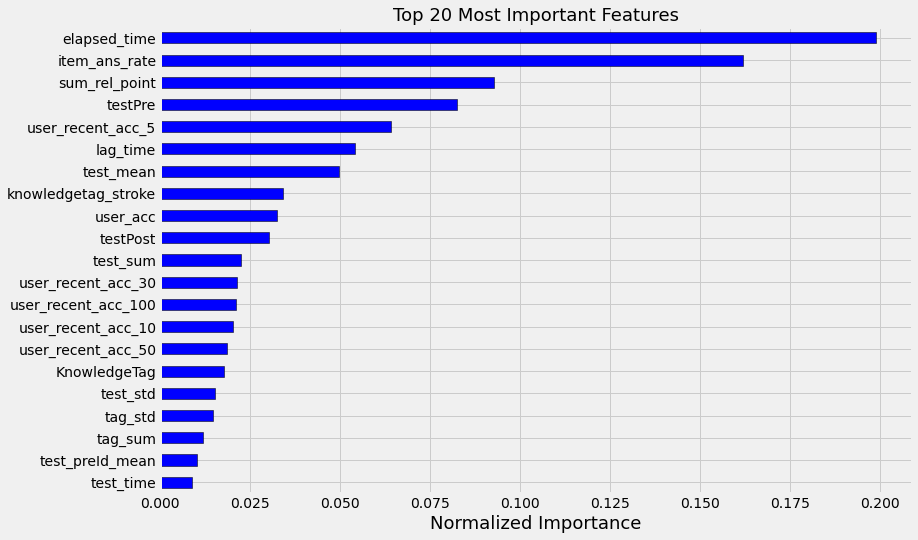

In [152]:
# sns.distplot(test_preds)
# plt.show()
# 기존 플롯
#fi_lgb = plot_feature_importances(fi)

## 5. Inference

In [52]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)
# TEST set: LEAVE LAST INTERACTION ONLY (users in test_data.csv)
test = test_df[test_df['answerCode'].isin([-1])]
# DROP ANSWERCODE
test = test.drop(['answerCode'], axis=1)

  0%|          | 0/42962 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/260114 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

In [91]:
%%time
# MAKE PREDICTION
y_oof, test_preds, fi_test = make_lgb_oof_pred(total_train, test, FEATS, params)

fold: 0, x_train.shape: (1262978, 21), x_val.shape: (1262978, 21)
[LightGBM] [Info] Number of positive: 826767, number of negative: 436211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3720
[LightGBM] [Info] Number of data points in the train set: 1262978, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654617 -> initscore=0.639397
[LightGBM] [Info] Start training from score 0.639397
[100]	training's auc: 0.846769	valid_1's auc: 0.844414
Fold 0 | AUC: 0.8444135387171378
--------------------------------------------------------------------------------
fold: 1, x_train.shape: (1262978, 21), x_val.shape: (1262978, 21)
[LightGBM] [Info] Number of positive: 826781, number of negative: 436197
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

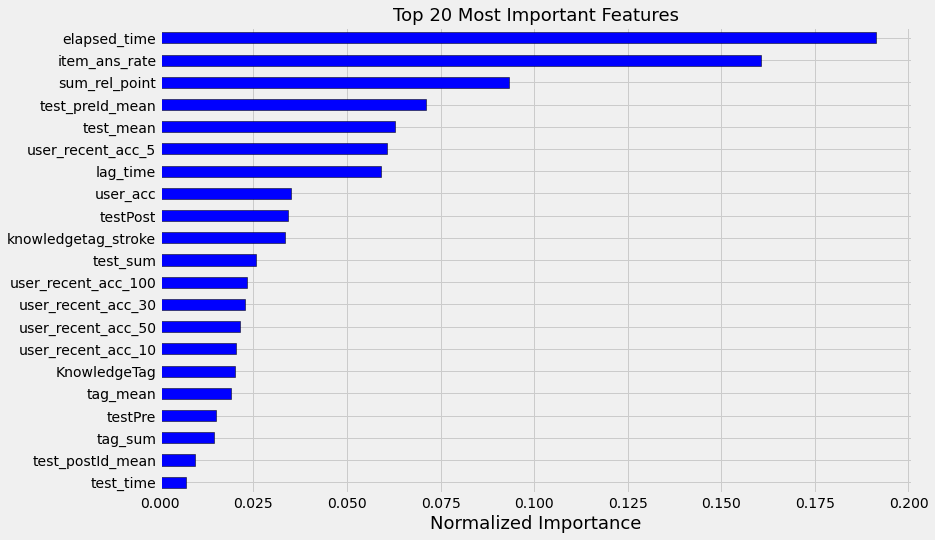

In [92]:
fi_test_plt = plot_feature_importances(fi_test)

### Submit

In [93]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "0614_ss1.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(test_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/0614_ss1.csv


In [ ]:
# same1 = pd.read_csv("output/0609_same.csv")
# same2 = pd.read_csv("output/0609_same2.csv")

## 6. Optuna objective func

### objective lgb 함수 정의

In [139]:
import optuna
def objective_lgb(trial, label=y_valid):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, val_preds, fi_val = make_lgb_oof_pred(train, valid, FEATS, params)
    # Validation 스코어 계산
    val_auc_lgb = roc_auc_score(label, y_oof)
    return val_auc_lgb

### Optuna study 생성, auc이기 때문에 최대화 하는 방향으로 하이퍼 파라미터 탐색

In [141]:
%%time
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=10) # 10회 동안 하이퍼 파라미터 탐색

In [77]:
total_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,day,user_correct_answer,user_total_answer,user_acc,...,tag9_ans_rate,knowledgetag_stroke,testPre,testPost,test_preId_mean,test_preId_sum,test_postId_mean,test_postId_sum,test_time,u_test_time_acc
618489,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,2019-12-31,0.0,0,0.000000,...,0.697222,0.0,60,14,0.712279,211037,0.614887,9500,2,0.774306
618490,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,2019-12-31,1.0,1,1.000000,...,0.697222,1.0,60,14,0.712279,211037,0.614887,9500,2,0.774306
618491,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,2019-12-31,2.0,2,1.000000,...,0.697222,2.0,60,14,0.712279,211037,0.614887,9500,2,0.774306
618492,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,2019-12-31,3.0,3,1.000000,...,0.697222,3.0,60,14,0.712279,211037,0.614887,9500,2,0.774306
618493,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,2019-12-31,4.0,4,1.000000,...,0.697222,4.0,60,14,0.712279,211037,0.614887,9500,2,0.774306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469745,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,2020-12-29,336.0,624,0.538462,...,0.676471,0.0,70,152,0.521761,164447,0.682317,7397,2,0.520408
469746,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,2020-12-29,336.0,625,0.537600,...,0.676471,0.0,70,152,0.521761,164447,0.682317,7397,2,0.520408
469747,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,2020-12-29,337.0,626,0.538339,...,0.676471,0.0,70,152,0.521761,164447,0.682317,7397,2,0.520408
469748,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,2020-12-29,337.0,627,0.537480,...,0.676471,0.0,70,152,0.521761,164447,0.682317,7397,2,0.520408


### Validation 스코어가 가장 잘 나온 하이퍼 파라미터 출력

In [ ]:
study_lgb.best_params

### 가장 성능이 잘 나온 Validation 스코어 출력

In [245]:
study_lgb.best_value